<img align=center src="https://rhyme.com/assets/img/logo-dark.png"></img>
<h2 align=center> Named Entity Recognition (NER) using LSTMs with Keras</h2>

### Task 1: Project Overview and Import Modules

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm
np.random.seed(0)
plt.style.use("ggplot")
tqdm.pandas()

import tensorflow as tf
print('Tensorflow version:', tf.__version__)
print('GPU detected:', tf.config.list_physical_devices('GPU'))

Tensorflow version: 2.8.0
GPU detected: []


### Task 2: Load and Explore the NER Dataset

*Essential info about tagged entities*:
- geo = Geographical Entity
- org = Organization
- per = Person
- gpe = Geopolitical Entity
- tim = Time indicator
- art = Artifact
- eve = Event
- nat = Natural Phenomenon

In [2]:
data = pd.read_csv('./ner_dataset.csv',encoding='latin1')
data = data.fillna(method='ffill')
data.head(20)

,Sentence #,Word,POS,Tag
0,Sentence: 1,Thousands,NNS,O
1,Sentence: 1,of,IN,O
2,Sentence: 1,demonstrators,NNS,O
3,Sentence: 1,have,VBP,O
4,Sentence: 1,marched,VBN,O
5,Sentence: 1,through,IN,O
6,Sentence: 1,London,NNP,B-geo
7,Sentence: 1,to,TO,O
8,Sentence: 1,protest,VB,O
9,Sentence: 1,the,DT,O


In [3]:
print(f"Palavras unicas: {data['Word'].nunique()}")
print(f"Tags unicas: {data['Tag'].nunique()}")


Palavras unicas: 35177
Tags unicas: 17


In [4]:
words = list(set(data['Word'].values))
words.append('ENDPAD')
num_words = len(words)
num_words

35178

In [5]:
tags = list(set(data['Tag'].values))
num_tags = len(tags)
num_tags

17

### Task 3: Retrieve Sentences and Corresponsing Tags

In [6]:
class SentenceGetter(object):
    def __init__(self,data):
        self.n_sent = 1
        self.data = data
        agg_func = lambda x : [(w,p,t) for w,p,t in zip(x['Word'].values.tolist(),
                                                            x['POS'].values.tolist(),
                                                            x['Tag'].values.tolist())]
        self.grouped = self.data.groupby("Sentence #").progress_apply(agg_func)
        self.sentences = [s for s in self.grouped]
    

In [7]:
getter = SentenceGetter(data)
sentences = getter.sentences

100%|██████████| 47959/47959 [00:04<00:00, 9608.66it/s] 


In [8]:
sentences[0]

[('Thousands', 'NNS', 'O'),
 ('of', 'IN', 'O'),
 ('demonstrators', 'NNS', 'O'),
 ('have', 'VBP', 'O'),
 ('marched', 'VBN', 'O'),
 ('through', 'IN', 'O'),
 ('London', 'NNP', 'B-geo'),
 ('to', 'TO', 'O'),
 ('protest', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('war', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('Iraq', 'NNP', 'B-geo'),
 ('and', 'CC', 'O'),
 ('demand', 'VB', 'O'),
 ('the', 'DT', 'O'),
 ('withdrawal', 'NN', 'O'),
 ('of', 'IN', 'O'),
 ('British', 'JJ', 'B-gpe'),
 ('troops', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('that', 'DT', 'O'),
 ('country', 'NN', 'O'),
 ('.', '.', 'O')]

### Task 4: Define Mappings between Sentences and Tags

In [9]:
word2idx = {w : i+1 for i , w in enumerate(words)}
tag2idx = {t : i for i , t in enumerate(tags)}

In [10]:
word2idx

{'Bouarfa': 1,
 'Truck': 2,
 'Annyaso': 3,
 'Petrasevic': 4,
 'SALIH': 5,
 'Islamophobia': 6,
 'Jundollah': 7,
 'applying': 8,
 'Fight': 9,
 'sites': 10,
 'gained': 11,
 'seven-man': 12,
 'remote-controlled': 13,
 'Rita': 14,
 'Am': 15,
 'experimenting': 16,
 "Ma'ariv": 17,
 'shed': 18,
 'Seydou': 19,
 'Israeli-controlled': 20,
 'booed': 21,
 'repatriate': 22,
 'civilian': 23,
 'extracted': 24,
 'opium-producing': 25,
 'actually': 26,
 'originates': 27,
 'Georgetown': 28,
 'confrontations': 29,
 'combing': 30,
 'Hongyao': 31,
 'cutoff': 32,
 'Vultures': 33,
 'Baker': 34,
 'exists': 35,
 'Muhsin': 36,
 'diplomats': 37,
 'obey': 38,
 'Tajbakhsh': 39,
 'Rohmer': 40,
 'Desi': 41,
 're-set': 42,
 '4th': 43,
 'phase': 44,
 'TITO': 45,
 'demise': 46,
 '1918': 47,
 'southeast': 48,
 'Ashwell': 49,
 '12,012': 50,
 'tormented': 51,
 'Cambodians': 52,
 'ARE': 53,
 'Armory': 54,
 'harmony': 55,
 'heights': 56,
 'mistletoe': 57,
 'vehicle': 58,
 '1,700': 59,
 'Yichang': 60,
 'ads': 61,
 'apartheid'

In [11]:
tag2idx

{'I-tim': 0,
 'I-per': 1,
 'I-nat': 2,
 'B-org': 3,
 'B-nat': 4,
 'I-gpe': 5,
 'B-tim': 6,
 'B-per': 7,
 'O': 8,
 'I-eve': 9,
 'B-eve': 10,
 'I-geo': 11,
 'B-gpe': 12,
 'I-art': 13,
 'B-geo': 14,
 'I-org': 15,
 'B-art': 16}

### Task 5: Padding Input Sentences and Creating Train/Test Splits

<module 'matplotlib.pyplot' from 'd:\\Anaconda\\lib\\site-packages\\matplotlib\\pyplot.py'>

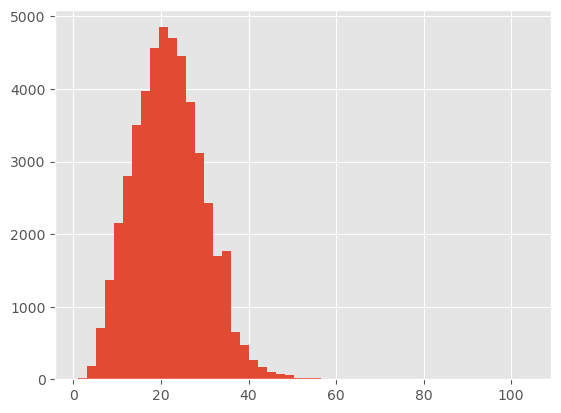

In [12]:
plt.hist([len(s) for s in sentences], bins = 50)
plt

In [13]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

max_len = 50

X = [[word2idx[w[0]] for w in s] for s in sentences]
X = pad_sequences(maxlen=max_len, sequences=X , padding='post',value=num_words-1)

y = [[tag2idx[w[2]] for w in s] for s in sentences]
y = pad_sequences(maxlen=max_len, sequences=y , padding='post',value=tag2idx['O'])
y = [to_categorical(i,num_classes=num_tags) for i in y]

In [14]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.1,random_state=1)

### Task 6: Build and Compile a Bidirectional LSTM Model

In [15]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Dense
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, Bidirectional

In [16]:
input_word = Input(shape =(max_len,))
model = Embedding(input_dim=num_words,output_dim=max_len,input_length=max_len)(input_word)
model = SpatialDropout1D(0.1)(model)
model = Bidirectional(LSTM(units=100,return_sequences=True,recurrent_dropout=0.1))(model)
out = TimeDistributed(Dense(num_tags, activation='softmax'))(model)
model = Model(input_word,out)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50)]              0         
                                                                 
 embedding (Embedding)       (None, 50, 50)            1758900   
                                                                 
 spatial_dropout1d (SpatialD  (None, 50, 50)           0         
 ropout1D)                                                       
                                                                 
 bidirectional (Bidirectiona  (None, 50, 200)          120800    
 l)                                                              
                                                                 
 time_distributed (TimeDistr  (None, 50, 17)           3417      
 ibuted)                                                         
                                                             

In [20]:
model.compile(optimizer="adam",
loss='categorical_crossentropy',
metrics=['accuracy'])

### Task 7: Train the Model

In [24]:
#!pip install livelossplot

In [23]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from livelossplot.tf_keras import PlotLossesCallback

In [ ]:
early_stopping = EarlyStopping(monitor='val_accuracy',patience=1)


### Task 8: Evaluate Named Entity Recognition Model